In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')

In [3]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


## Preparing the dataset

In [4]:
# Fill missing values with zeros.
df = df.fillna(0)

In [5]:
df.describe()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,num_doors,fuel_efficiency_mpg
count,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000
mean,199.708368,3.765664,138.738355,3001.280993,13.582275,2011.484027,-0.006080,14.985243
std,49.455319,2.130715,48.401189,497.894860,5.025294,6.659808,1.020689,2.556468
min,10.000000,0.000000,0.000000,952.681761,0.000000,2000.000000,-4.000000,6.200971
25%,170.000000,2.000000,124.000000,2666.248985,12.600000,2006.000000,-1.000000,13.267459
50%,200.000000,4.000000,146.000000,2993.226296,14.700000,2012.000000,0.000000,15.006037
75%,230.000000,5.000000,168.000000,3334.957039,16.500000,2017.000000,1.000000,16.707965
max,380.000000,13.000000,271.000000,4739.077089,24.300000,2023.000000,4.000000,25.967222


In [6]:
# train/validation/test split with 60%/20%/20% distribution
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

In [7]:
y_train = (df_train['fuel_efficiency_mpg']).values
y_val = (df_val['fuel_efficiency_mpg']).values
y_test = (df_test['fuel_efficiency_mpg']).values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [8]:
# Use DictVectorizer(sparse=True) to turn the dataframes into matrices
# DictVectorizer requires a list of dictionaries - convert:
dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')

# Instantiate DictVectorizer and fit to training dataset
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

## Question 1

In [9]:
# Fit the Decision Tree regressor to the data
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_train)

In [10]:
feature_index = dt.tree_.feature[0]  # index of feature used for splitting node 0 (root node), i.e the first split 
first_split_feature = dv.feature_names_[feature_index]
print(f"Feature for first split: {first_split_feature}")

Feature for first split: vehicle_weight


## Question 2

In [11]:
# Train a random forest regressor and calculate the RMSE of this model on the validation data
rf = RandomForestRegressor(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

In [12]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [13]:
_rmse = rmse(y_val, y_pred)
print(f"RMSE of validation data: {_rmse:.3f}")

RMSE of validation data: 0.460


## Question 3

In [14]:
parameters, n_estimators_results = [], []
for parameter in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=parameter, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    _rmse = rmse(y_val, y_pred)
    parameters.append(parameter)
    n_estimators_results.append(_rmse)

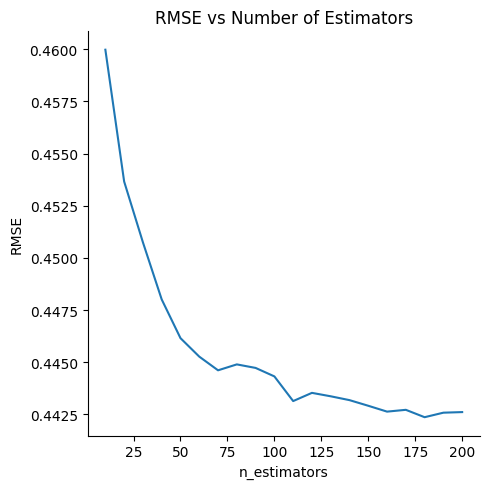

In [15]:
rf_df = pd.DataFrame({'n_estimators':parameters, 'RMSE': n_estimators_results})

sns.relplot(rf_df, kind="line",x="n_estimators", y="RMSE")
plt.title('RMSE vs Number of Estimators')
plt.tight_layout()

In [16]:
# After n_estimators=70, RMSE stops improving - overall small improvements thereafter

## Question 4

In [17]:
depth_results = {}

for depth in [10, 15, 20, 25]:
    n_estimators_results = []
    for parameter in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=parameter, random_state=1, max_depth=depth)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        _rmse = rmse(y_val, y_pred)
        parameters.append(parameter)
        n_estimators_results.append(_rmse)
    depth_results[f"Depth: {depth}"] = n_estimators_results

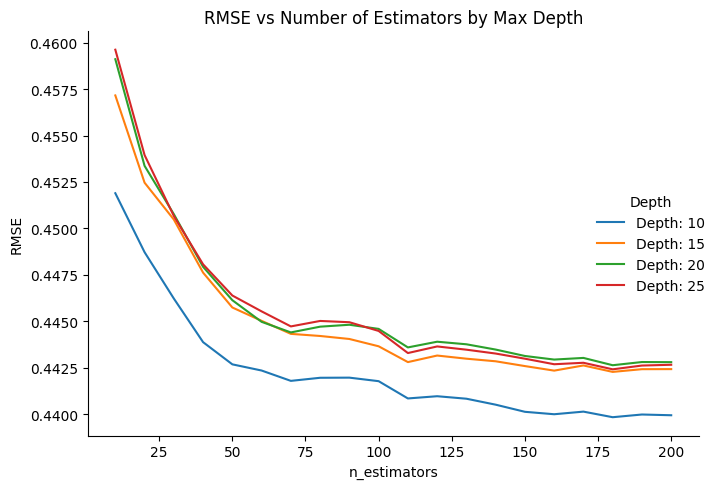

In [18]:
parameters = list(range(10, 201, 10))

# Convert your nested dictionary to a DataFrame
plot_data = []
for depth_key, rmse_values in depth_results.items():
    for param, rmse_val in zip(parameters, rmse_values):
        plot_data.append({
            'n_estimators': param,
            'RMSE': rmse_val,
            'Depth': depth_key  
        })

df_plot = pd.DataFrame(plot_data)

# Create the line plot
sns.relplot(data=df_plot, x='n_estimators', y='RMSE', hue='Depth', kind='line', markers=True, aspect=1.2)

plt.title('RMSE vs Number of Estimators by Max Depth')
plt.tight_layout()

In [19]:
# Read off the chart that the best max depth is 10, since it produces the lowest RMSE

## Question 5

In [20]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, max_depth=20)
rf.fit(X_train, y_train)
feature_importances = dict( zip(dv.feature_names_, rf.feature_importances_) )

feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

In [21]:
feature_importances

{'vehicle_weight': np.float64(0.9591620125325987),
 'horsepower': np.float64(0.016040214819390403),
 'acceleration': np.float64(0.011470716492980844),
 'engine_displacement': np.float64(0.003269323417164303),
 'model_year': np.float64(0.0031822984145892436),
 'num_cylinders': np.float64(0.0023586709360923362),
 'num_doors': np.float64(0.001591133064507162),
 'origin=USA': np.float64(0.0005551519590830011),
 'origin=Europe': np.float64(0.0005203580827405653),
 'origin=Asia': np.float64(0.00047610304607445227),
 'drivetrain=All-wheel drive': np.float64(0.0003818097503064222),
 'fuel_type=Diesel': np.float64(0.00034369341131184716),
 'fuel_type=Gasoline': np.float64(0.00033667198836755764),
 'drivetrain=Front-wheel drive': np.float64(0.0003118420847931986)}

In [22]:
# vehicle_weight is the most important feature

## Question 6

In [23]:
# data needs to be in a DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

In [24]:
# Watchlist
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [25]:
xgb_params = {
    'eta': 0.3, #
    'max_depth': 6, #
    'min_child_weight': 1, #
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}

In [26]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=10)

[0]	train-rmse:1.81393	val-rmse:1.85444
[10]	train-rmse:0.37115	val-rmse:0.43896
[20]	train-rmse:0.33553	val-rmse:0.43376
[30]	train-rmse:0.31475	val-rmse:0.43752
[40]	train-rmse:0.30202	val-rmse:0.43968
[50]	train-rmse:0.28456	val-rmse:0.44140
[60]	train-rmse:0.26768	val-rmse:0.44290
[70]	train-rmse:0.25489	val-rmse:0.44531
[80]	train-rmse:0.24254	val-rmse:0.44689
[90]	train-rmse:0.23193	val-rmse:0.44839
[99]	train-rmse:0.21950	val-rmse:0.45018


In [27]:
xgb_params = {
    'eta': 0.1, #
    'max_depth': 6, #
    'min_child_weight': 1, #
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}

In [28]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=10)

[0]	train-rmse:2.28944	val-rmse:2.34561
[10]	train-rmse:0.91008	val-rmse:0.94062
[20]	train-rmse:0.48983	val-rmse:0.53064
[30]	train-rmse:0.38342	val-rmse:0.44289
[40]	train-rmse:0.35343	val-rmse:0.42746
[50]	train-rmse:0.33998	val-rmse:0.42498
[60]	train-rmse:0.33054	val-rmse:0.42456
[70]	train-rmse:0.32202	val-rmse:0.42503
[80]	train-rmse:0.31667	val-rmse:0.42563
[90]	train-rmse:0.31059	val-rmse:0.42586
[99]	train-rmse:0.30419	val-rmse:0.42623


In [29]:
# Smaller eta/learning rate (0.1) gives a better (i.e. lower) RMSE